# Libraries

In [1]:
import gdown
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Data Information

In [2]:
url = 'https://drive.google.com/file/d/1_rPu9vrnVOsUWIYnJd8at90PMEiuJZ5f/view?usp=drive_link'

train_file_id = url.split('/')[-2]

dwn_url = 'https://drive.google.com/uc?id=' + train_file_id

gdown.download(dwn_url, 'train.csv', quiet=False)

df = pd.read_csv('train.csv')

Downloading...
From: https://drive.google.com/uc?id=1_rPu9vrnVOsUWIYnJd8at90PMEiuJZ5f
To: /content/train.csv
100%|██████████| 33.1k/33.1k [00:00<00:00, 35.7MB/s]


In [3]:
df.head()

,realtime_start,value,date,realtime_end
0,2019-12-06,156309.0,1952-01-01,2019-12-06
1,2019-12-06,156527.0,1952-02-01,2019-12-06
2,2019-12-06,156731.0,1952-03-01,2019-12-06
3,2019-12-06,156943.0,1952-04-01,2019-12-06
4,2019-12-06,157140.0,1952-05-01,2019-12-06


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 816 entries, 0 to 815
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   realtime_start  816 non-null    object 
 1   value           816 non-null    float64
 2   date            816 non-null    object 
 3   realtime_end    816 non-null    object 
dtypes: float64(1), object(3)
memory usage: 25.6+ KB


In [5]:
df.describe()

,value
count,816.000000
mean,243847.767826
std,50519.140567
min,156309.000000
25%,201725.250000
50%,239557.500000
75%,289364.250000
max,330309.946000


# Data Preprocessing

## Features Selection

In [6]:
df = df[['date', 'value']]
df.head()

,date,value
0,1952-01-01,156309.0
1,1952-02-01,156527.0
2,1952-03-01,156731.0
3,1952-04-01,156943.0
4,1952-05-01,157140.0


## Time Features

In [7]:
df_model = df.copy()
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df.head()

<ipython-input-7-98527ab89e23>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])
<ipython-input-7-98527ab89e23>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['date'].dt.year


,date,value,year,month,day
0,1952-01-01,156309.0,1952,1,1
1,1952-02-01,156527.0,1952,2,1
2,1952-03-01,156731.0,1952,3,1
3,1952-04-01,156943.0,1952,4,1
4,1952-05-01,157140.0,1952,5,1


# Exploratory Data Analysis

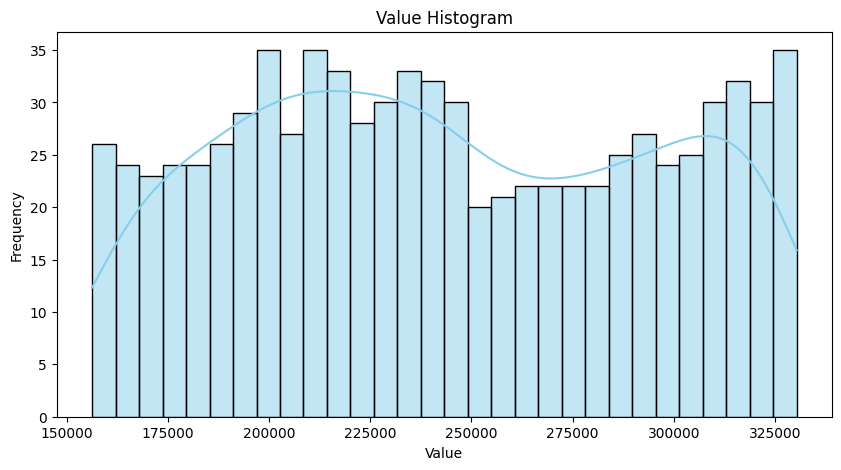

In [8]:
plt.figure(figsize = (10, 5))

ax = sns.histplot(data=df, x='value', kde=True, bins=30, color='skyblue', edgecolor='black')  # Menambahkan parameter
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_title('Value Histogram')

plt.show()

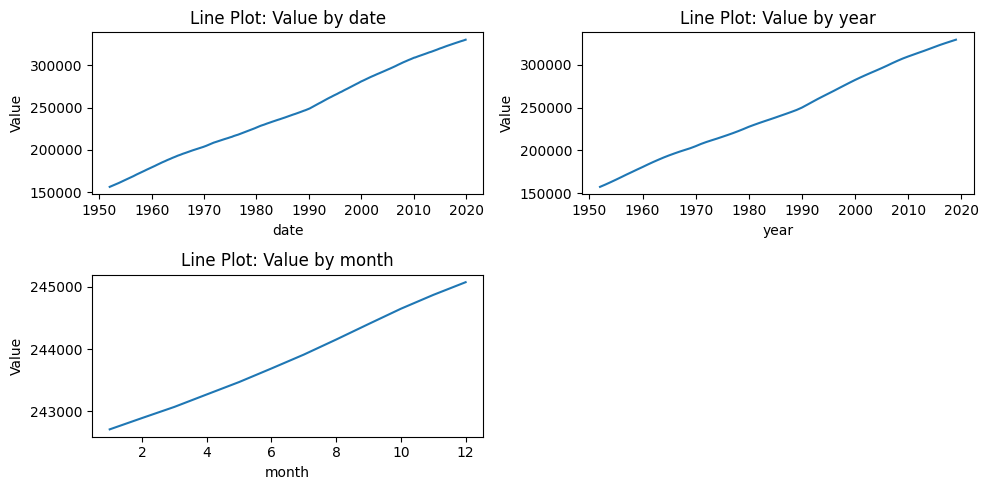

In [9]:
time_columns = ['date', 'year', 'month']

fig, axes = plt.subplots(2, 2, figsize=(10, 5))
axes = axes.flatten()

for i, time_col in enumerate(time_columns):
  ax = sns.lineplot(data=df, x=time_col, y='value', ax=axes[i], errorbar=None)
  ax.set_xlabel(time_col)
  ax.set_ylabel('Value')
  ax.set_title(f'Line Plot: Value by {time_col}')

fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

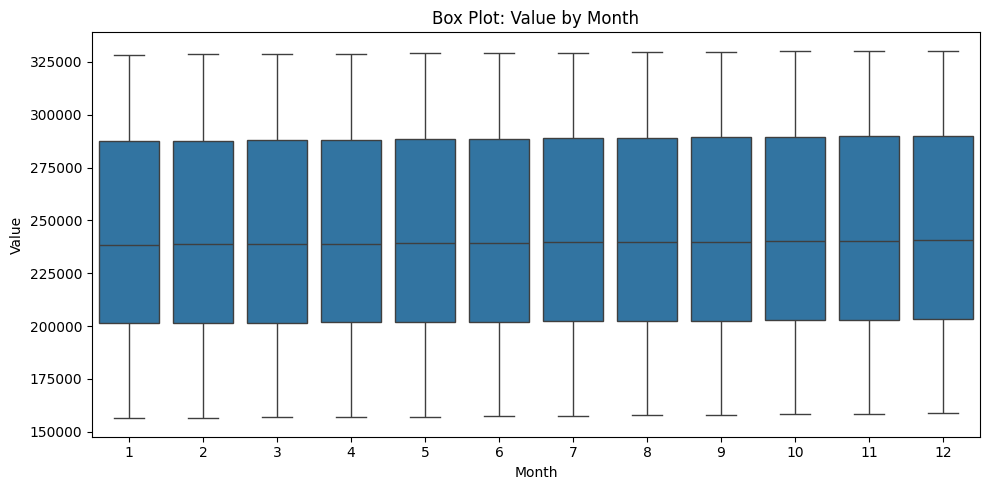

In [10]:
plt.figure(figsize = (10,5))

ax = sns.boxplot(data=df, x='month', y='value')
ax.set_xlabel('Month')
ax.set_ylabel('Value')
ax.set_title('Box Plot: Value by Month')

plt.tight_layout()
plt.show()

# Decomposition

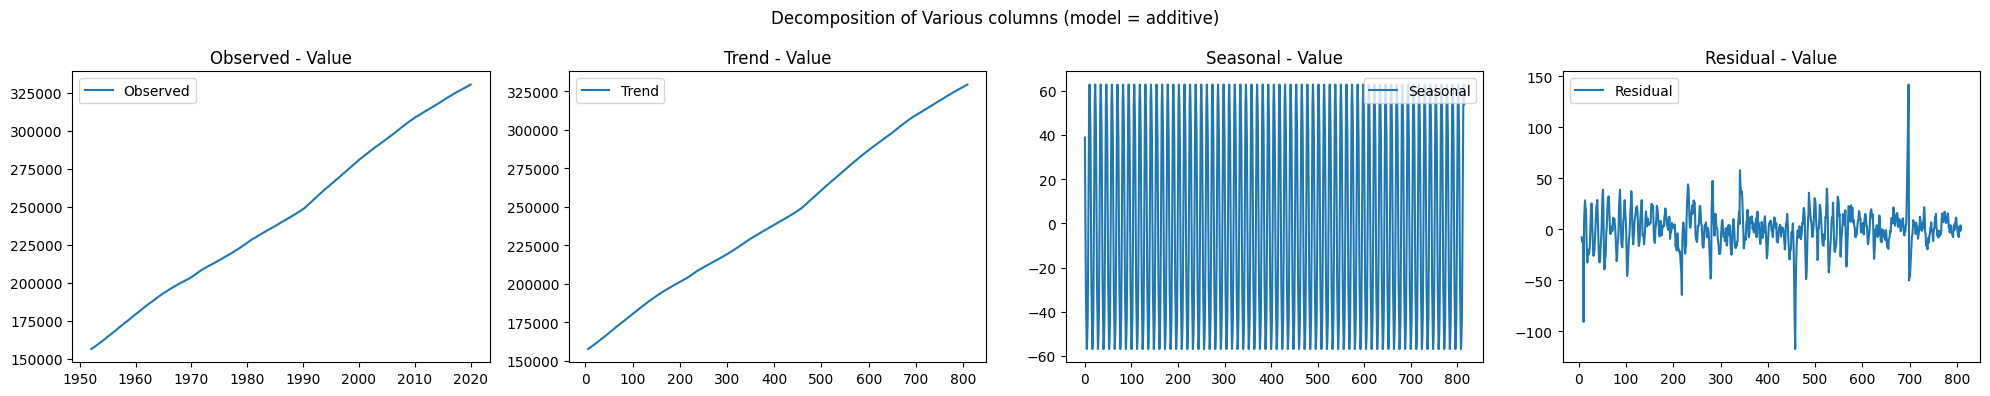

In [11]:
df.set_index('date', inplace = True)
fig, axes = plt.subplots(1, 4, figsize = (20, 4))

monthly_data = df['value'].resample('M').sum()
decomposition = seasonal_decompose(monthly_data.values, period = 12, model = 'additive')

axes[0].plot(monthly_data, label = 'Observed')
axes[0].legend(loc = 'best')
axes[0].set_title('Observed - Value')

axes[1].plot(decomposition.trend, label = 'Trend')
axes[1].legend(loc = 'best')
axes[1].set_title('Trend - Value')

axes[2].plot(decomposition.seasonal, label = 'Seasonal')
axes[2].legend(loc = 'best')
axes[2].set_title('Seasonal - Value')

axes[3].plot(decomposition.resid, label = 'Residual')
axes[3].legend(loc = 'best')
axes[3].set_title('Residual - Value')

plt.suptitle('Decomposition of Various columns (model = additive)')
plt.tight_layout()
plt.show()

# Checking Stationary
## Autocorrelation (ACF) and Partial Autocorrelation (PACF)

<Figure size 1000x500 with 0 Axes>

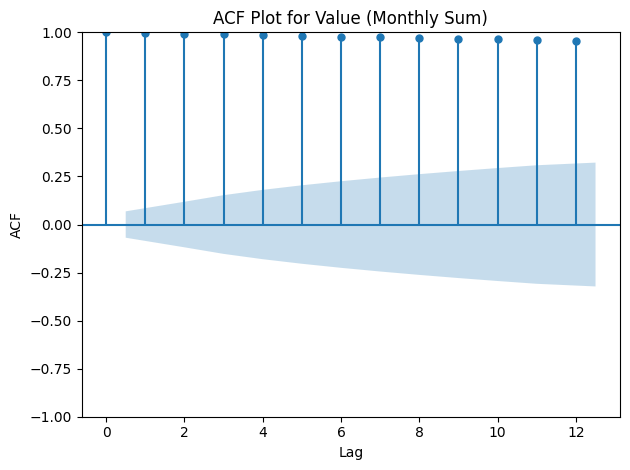

In [12]:
plt.figure(figsize=(10, 5))

plot_acf(x=monthly_data, lags=12)

plt.title('ACF Plot for Value (Monthly Sum)')
plt.xlabel('Lag')
plt.ylabel('ACF')

plt.tight_layout()
plt.show()

<Figure size 1000x500 with 0 Axes>

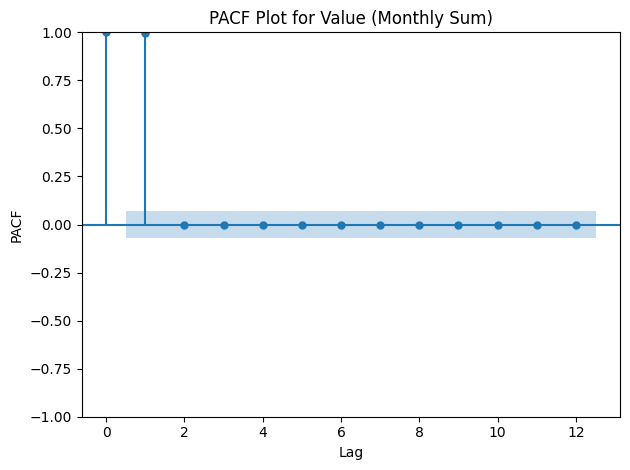

In [13]:
plt.figure(figsize=(10, 5))

plot_pacf(x=monthly_data, lags=12)

plt.title('PACF Plot for Value (Monthly Sum)')
plt.xlabel('Lag')
plt.ylabel('PACF')

plt.tight_layout()
plt.show()

# ADF Test

In [14]:
GREEN = '\033[92m'
RED = '\033[91m'
RESET = '\033[0m'

print(f"Augmented Dickey-Fuller test result for: Value")
result = adfuller(df['value'], autolag='AIC')

print(f"ADF test statistic: {result[0]}")
print(f"p-value: {result[1]}")

print("Critical Values:")
for key, val in result[4].items():
  print("\t%s : %f" % (key, val))

if result[1] > 0.05:
  print(RED + "Series is not stationary. Further differencing is needed.\n" + RESET)
else:
  print(GREEN + "Series is stationary. No further differencing is required.\n" + RESET)

Augmented Dickey-Fuller test result for: Value
ADF test statistic: -0.6653174110243182
p-value: 0.8555297778919786
Critical Values:
	1% : -3.438571
	5% : -2.865169
	10% : -2.568702
Series is not stationary. Further differencing is needed.



# Modelling Sarima

In [15]:
df = df[['value']]
df1 = df.copy()
df1.head()

,value
date,
1952-01-01,156309.0
1952-02-01,156527.0
1952-03-01,156731.0
1952-04-01,156943.0
1952-05-01,157140.0


In [16]:
df1['value_diff'] = df1['value'].diff().fillna(0)
df1['value_diff_diff'] = df1['value_diff'].diff().fillna(0)

print(f"Augmented Dickey-Fuller test result for: Value")
result = adfuller(df1['value_diff_diff'], autolag='AIC')

print(f"ADF test statistic: {result[0]}")
print(f"p-value: {result[1]}")

print("Critical Values:")
for key, val in result[4].items():
  print("\t%s : %f" % (key, val))

if result[1] > 0.05:
  print(RED + "Series is not stationary. Further differencing is needed.\n" + RESET)
else:
  print(GREEN + "Series is stationary. No further differencing is required.\n" + RESET)

Augmented Dickey-Fuller test result for: Value
ADF test statistic: -6.934877543545924
p-value: 1.0609284425005894e-09
Critical Values:
	1% : -3.438613
	5% : -2.865187
	10% : -2.568712
Series is stationary. No further differencing is required.



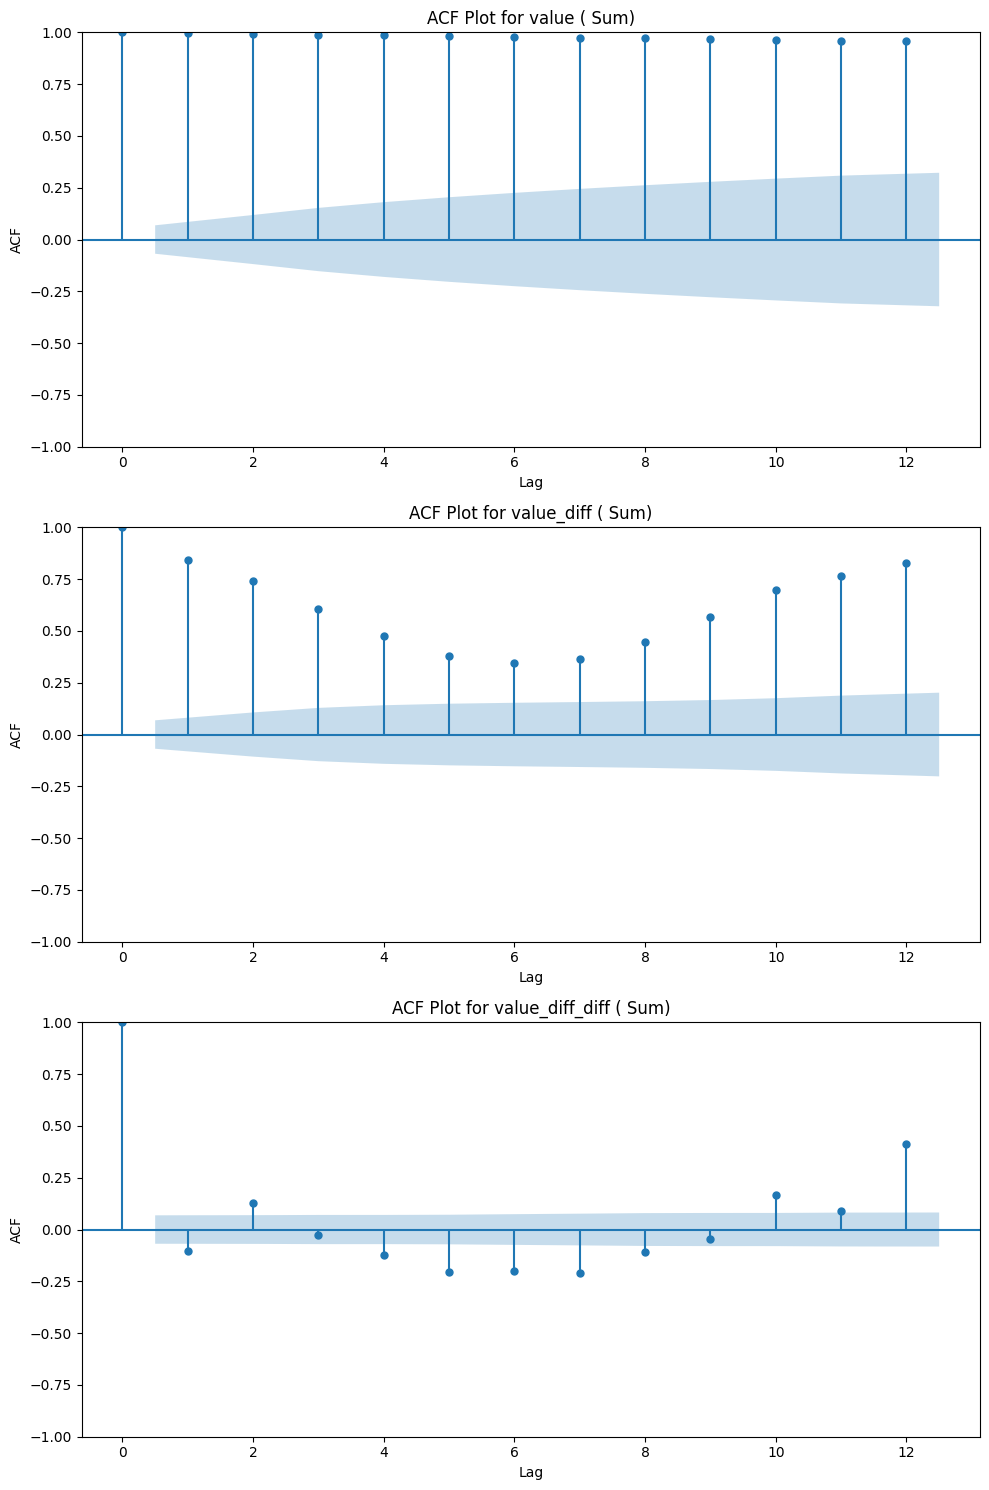

In [17]:
columns = ['value', 'value_diff', 'value_diff_diff']

fig, axes = plt.subplots(nrows=len(columns), ncols=1, figsize=(10, 5 * len(columns)))
axes = axes.flatten()

for i, col in enumerate(columns):
  ax = axes[i]
  plot_acf(x=df1[col], ax=ax, lags=12)
  ax.set_title(f'ACF Plot for {col} ( Sum)')
  ax.set_xlabel('Lag')
  ax.set_ylabel('ACF')

plt.tight_layout()
plt.show()

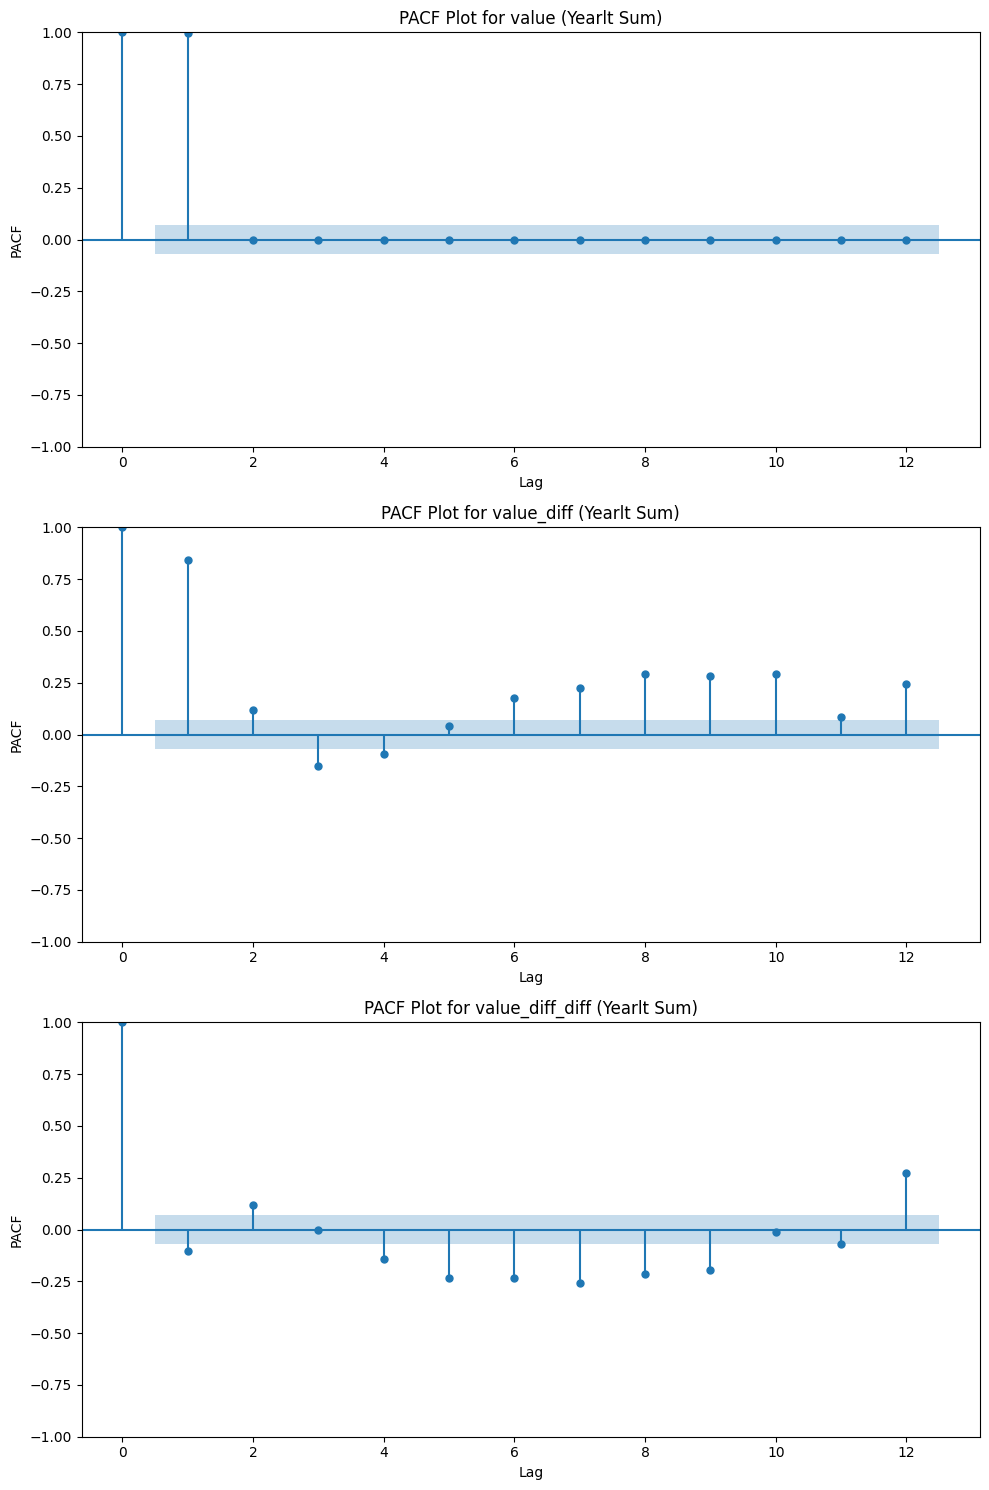

In [18]:
columns = ['value', 'value_diff', 'value_diff_diff']

fig, axes = plt.subplots(nrows=len(columns), ncols=1, figsize=(10, 5 * len(columns)))
axes = axes.flatten()

for i, col in enumerate(columns):
  ax = axes[i]
  plot_pacf(x=df1[col], ax=ax, lags=12)
  ax.set_title(f'PACF Plot for {col} (Yearlt Sum)')
  ax.set_xlabel('Lag')
  ax.set_ylabel('PACF')

plt.tight_layout()
plt.show()

In [19]:
df_sarima = df_model[['date','value']].copy()
df_sarima['date'] = pd.to_datetime(df_sarima['date'])
df_sarima = df_sarima.resample('M', on='date').mean()
df_sarima.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 816 entries, 1952-01-31 to 2019-12-31
Freq: M
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   816 non-null    float64
dtypes: float64(1)
memory usage: 12.8 KB


## Train Test Split

In [20]:
train_size = int(len(df_sarima) * 0.8)
train, test = df_sarima.iloc[:train_size], df_sarima.iloc[train_size:]

# Sarima

In [21]:
model = SARIMAX(train, order = (1,2,1), seasonal_order = (1,2,1,12))
fitted_model = model.fit()
print(fitted_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                  652
Model:             SARIMAX(1, 2, 1)x(1, 2, 1, 12)   Log Likelihood               -2608.447
Date:                            Sun, 21 Jul 2024   AIC                           5226.893
Time:                                    16:13:46   BIC                           5249.090
Sample:                                01-31-1952   HQIC                          5235.517
                                     - 04-30-2006                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0527      0.049      1.085      0.278      -0.042       0.148
ma.L1         -0.5972      0.048   

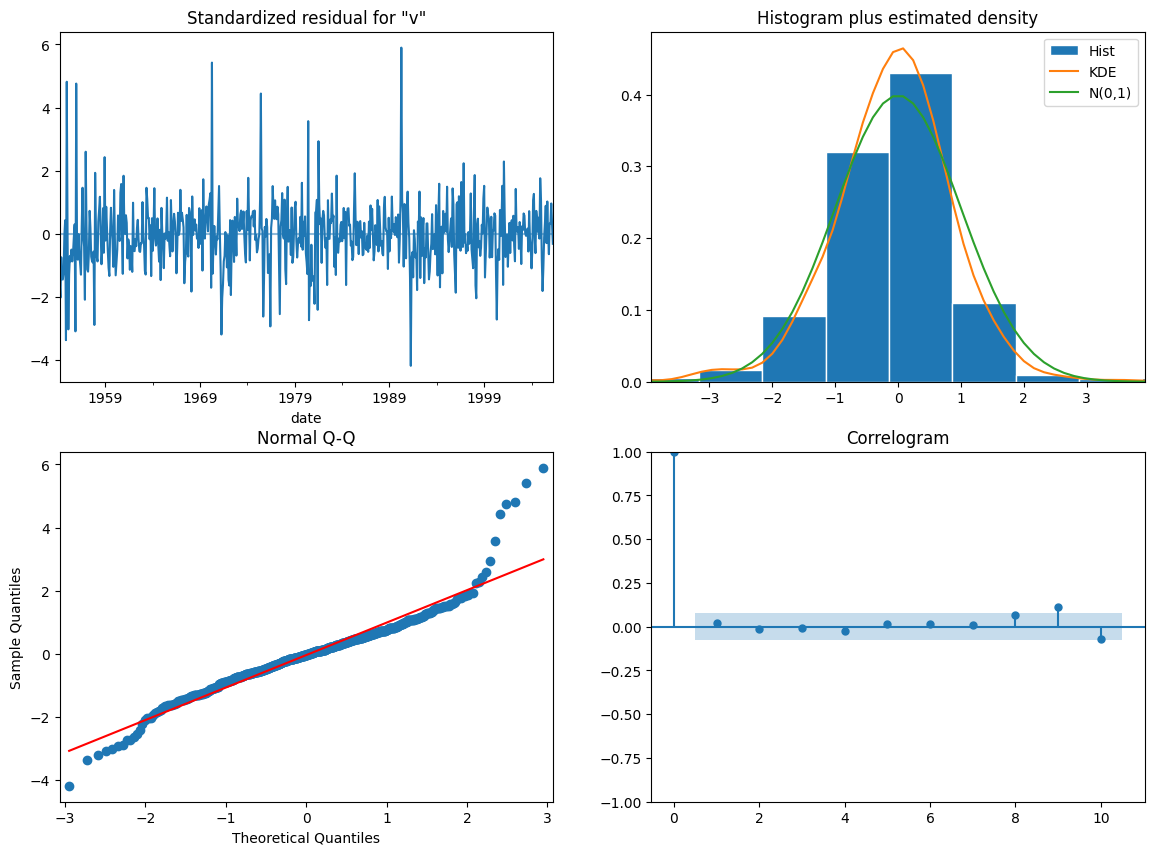

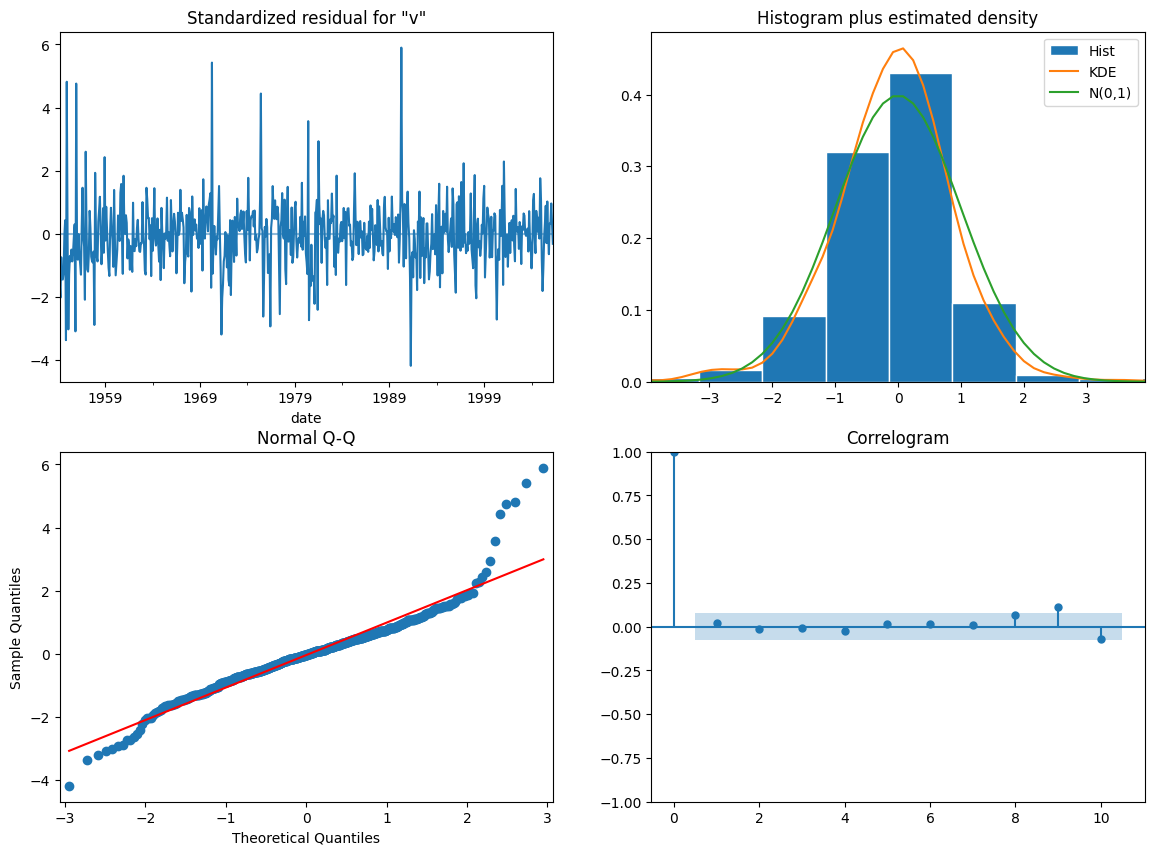

In [22]:
fitted_model.plot_diagnostics(figsize = (14,10))

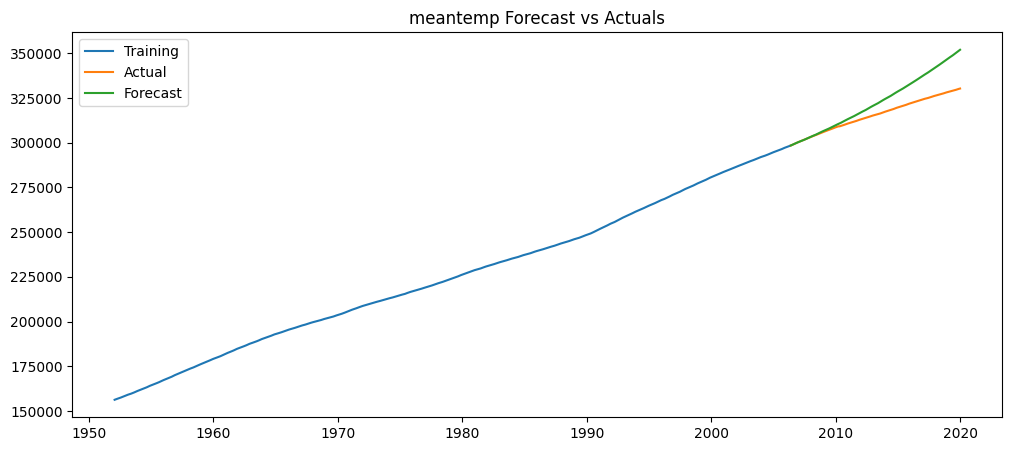

In [23]:
forecast_steps = len(test)
forecast = fitted_model.forecast(steps = forecast_steps)
forecast_series = pd.Series(forecast, index = test.index)

plt.figure(figsize=(12, 5))
plt.plot(train, label='Training')
plt.plot(test, label='Actual')
plt.plot(forecast_series, label='Forecast')
plt.title('meantemp Forecast vs Actuals')
plt.legend(loc='upper left')
plt.show()

In [24]:
def forecast_accuracy(forecast, actual):
  mape = np.mean(np.abs(forecast - actual) / np.abs(actual))
  mae = np.mean(np.abs(forecast - actual))
  rmse = np.sqrt(np.mean((forecast - actual)**2))
  smape = 100 * np.mean(2 * np.abs(forecast - actual) / (np.abs(forecast) + np.abs(actual)))

  return mape, mae, rmse, smape

mape, mae, rmse, smape = forecast_accuracy(forecast, test.values.flatten())
print(f"MAPE: {mape}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"SMAPE: {smape}")

MAPE: 0.022577142705177668
MAE: 7295.646315231238
RMSE: 9810.511746347698
SMAPE: 2.2133348451348214
